In [1]:
import sys
print(sys.version)

3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from gensim.models import Word2Vec

In [4]:
from sklearn.manifold import t_sne

In [5]:
from MulticoreTSNE import MulticoreTSNE

#### Data loading

In [6]:
data = pd.read_csv("titles_books.csv")
data.sample(10)

,Unnamed: 0,title
19600,6748623138,SF 2/2012 KSIĘŻYC PRAWDOPODOBIEŃSTWA [KSIĄŻKA]
42115,6849389313,Jim Butcher Akta Dresdena 10 Drobna przysługa ...
29821,6829031459,WŁADCA PIERŚCIENI DRUŻYNA PIERŚCIENIA Tolkien
6619,6077992025,Artemis Fowl Kod wieczności - Eoin Colfer
5095,5847160907,BUDOWNICZOWIE PIERŚCIENIA - LARRY NIVEN
41101,6848371988,ANDRE NORTON GRYF W CHWALE ____!
40309,6847522131,GRA O TRON 1-8 MIĘKKA - Martin PIEŚŃ LODU I OGNIA
18535,6745746418,ksiazka-BAŚNIOBÓR 2 GWIAZDA WIECZORNA WSCHODZI...
14778,6684750641,KRYPTONIM PSIMA Mirosław P Jabłoński UNIKAT OK...
31565,6832310202,KRÓL MAGII Lev Grossman GDAŃSK


In [25]:
import re
def getWords(text):
    splitted_text = text.split()
    new_splitted_text = []
    for item in splitted_text:
        if len(item) == 1:
            item = item.lower()
        new_splitted_text.append(item)
    new_text = " ".join(new_splitted_text)
    new_text = re.sub("\.", " ", new_text)
    new_text = re.sub("_", "", new_text)
    new_text = re.sub("(?<= [A-Z]{1}) +((?=[A-Z] )|(?=[A-Z]$))", "", new_text)
    all_words = re.compile('\w+').findall(new_text)
    return [words.lower() for words in all_words if len(words)>1]

In [26]:
titles = [getWords(title) for title in data.title]

#### Model training

In [27]:
VECTOR_DIM = 100

In [28]:
model = Word2Vec(titles, size=VECTOR_DIM, min_count=0)

In [29]:
model.similar_by_word(word="tolkien".lower(), topn=20)

[('hobbit', 0.9965576529502869),
 ('powrotem', 0.995455265045166),
 ('silmarillion', 0.9953170418739319),
 ('podlesia', 0.9885616898536682),
 ('jrr', 0.9871971607208252),
 ('skibniewska', 0.9858812689781189),
 ('kropce', 0.9851657152175903),
 ('pierścienia', 0.9839641451835632),
 ('tam', 0.9836831092834473),
 ('pierścieni', 0.9834772348403931),
 ('dżil', 0.9833084940910339),
 ('władca', 0.9823684692382812),
 ('niedokończone', 0.9817066192626953),
 ('tomie', 0.9799332618713379),
 ('dwie', 0.9794735908508301),
 ('objaśnieniami', 0.9789531826972961),
 ('tol', 0.9782145023345947),
 ('ósma', 0.9768832325935364),
 ('ciepło', 0.9757832884788513),
 ('kropka', 0.9735009670257568)]

In [30]:
def get_word_score(model, word):
    try:
        score = model.wv[word]
    except:
        score = np.repeat(np.nan, repeats=VECTOR_DIM)
    return score

def get_title_score(model, title):
    title_parsed = getWords(title)
    mean_score = np.nanmean([get_word_score(model, i) for i in title_parsed], axis = 0) #nanmean to jak na.rm=TRUE w R
    return mean_score

In [31]:
v1 = get_title_score(model, "Tolkien - Władca pierścieni - Trylogia")
v2 = get_title_score(model, "NAUKA ŚWIATA DYSKU I - Terry Pratchett")
np.sum((v1-v2)**2)

93.815063

In [32]:
vectorized_titles = np.array([get_title_score(model, title) for title in data.title])

In [33]:
vectorized_titles_sample = vectorized_titles[np.random.choice(vectorized_titles.shape[0], size = 20000, replace = False)]

#### T-SNE visualizations

In [34]:
tsne_transformer = MulticoreTSNE(verbose = 1, n_jobs=4, perplexity=50)

In [35]:
tnsed_titles = tsne_transformer.fit_transform(vectorized_titles_sample.astype(np.float64))

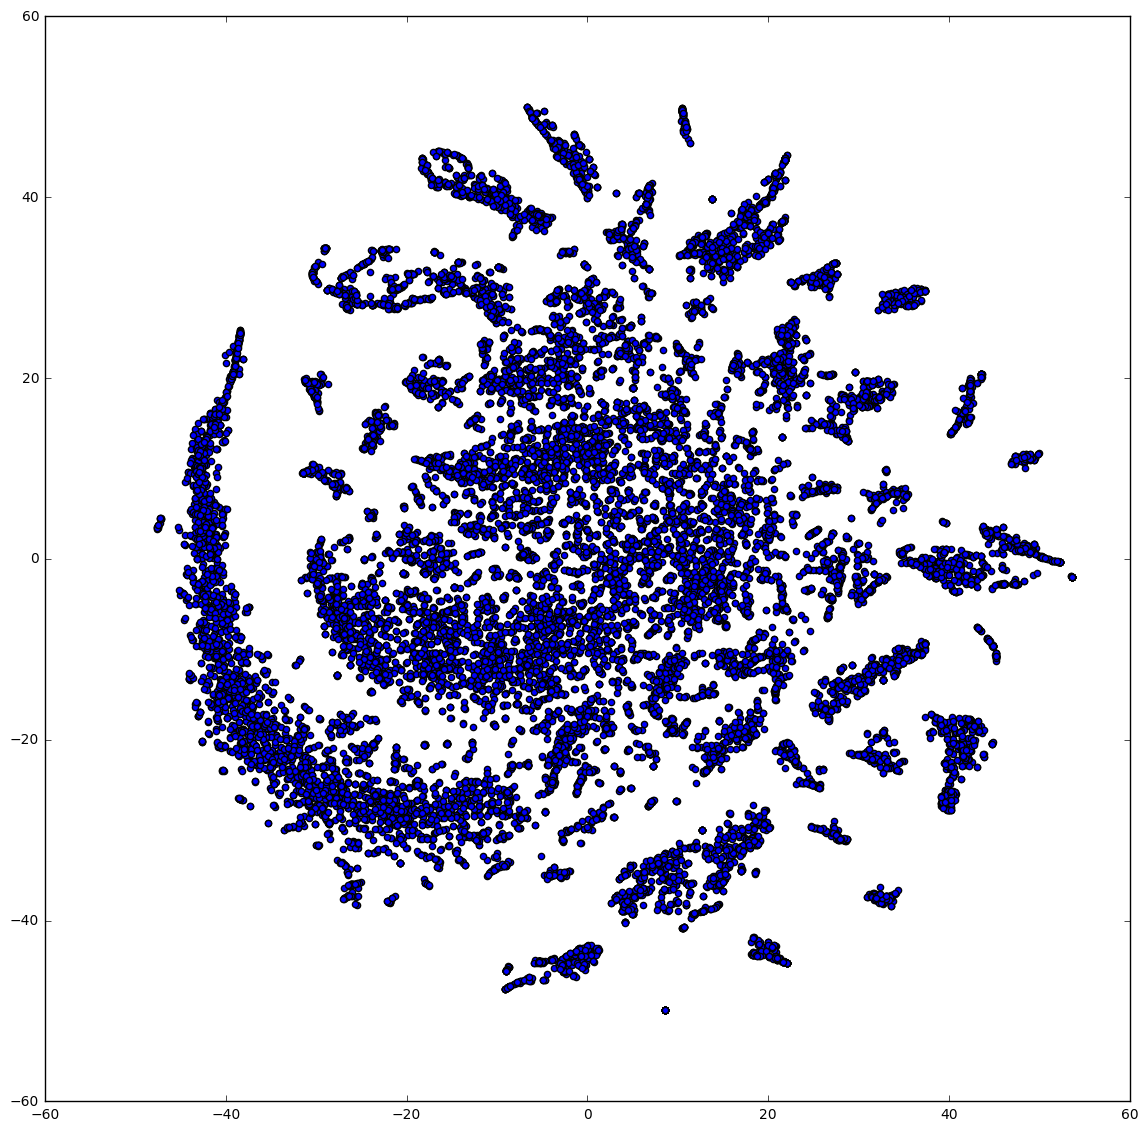

In [36]:
plt.figure(figsize=(14,14))
plt.scatter(tnsed_titles[:, 0], tnsed_titles[:, 1])
plt.show()